In [138]:
from scipy.special import comb
from scipy.misc import factorial2
from scipy.special import lambertw
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from math import exp, sqrt, log,pow
import gc
import random
import matplotlib as mpl
from decimal import *
getcontext().prec = 64

mpl.rcParams['figure.figsize'] = (10,10)

# Magnetic coins exact energy degenercy

## $ \Omega(\epsilon) = \sum_{p = 0}^{\epsilon/2} {N \choose N-2p}{N-2p \choose \frac{N-2p-\epsilon}{2}} (2p-1)!!$

## Note: This is the exact relation.

In [139]:
def n_p_mag_exact(L,p):
    n_pairs = 2*p
    #possible combinations for p pairs is (2p-1)!!
    return  Decimal(int(factorial2(n_pairs-1)))

def n_s_mag_exact(L,p,e):
    n_pairs = 2*p
    n_singles = L - n_pairs
    #The energy or e is always negative or zero
    #so the number os up sites is half of the all non-paires minue the energy 
    #note that e or energy is correspond to down sites that has not canceled by up ones
    n_up = (n_singles+e )/2
    #first ons is choosing n_singles from all sites or L
    #second one is choosing n_up from n_singles
    ret = Decimal(comb(L, n_singles, exact=True)) * Decimal(comb(n_singles, n_up, exact=True))
    return Decimal(1) if(ret == Decimal(0)) else ret

def n_E_mag_exact(L):
    n_Es = np.zeros(L+1)
    #enumarte on all energies from -Ground states to zero
    for idx,e in enumerate(range(-L,1,2)):
        #enumartes all possible paires for current energy
        for p in range(0,int((L+e)/2+1)):
            #sum the previous configurations number for current energy
            #with the current one for the p pairs and remaining up/down sites
            n_Es[idx] = Decimal(n_Es[idx]) + n_p_mag_exact(L,p)*n_s_mag_exact(L,p,e)
        #calculate the positive energies by using the symtery argument
        n_Es[L-idx] = n_Es[idx]
    return n_Es

# Partition function

## $Z = \sum_{\epsilon_i}  \Omega(\epsilon_i) e^{- \tilde{\beta} \epsilon_i}$

## Note: The partition function is absolute. No density is used here.

In [155]:
def partition_F_2(omega_E,beta_tilde):
    """
    omega_E: energy degeneracy array
    beta_tilde: temprature like real number
    Return: Partition function
    """
    #L is the size of the 1D Ising chain
    L = len(omega_E)-1    
    #Calculate the partition function at T
    Z = sum(map(lambda E,n_E: Decimal(0.0) if(n_E == 0) else Decimal(-float(beta_tilde)*E + log(n_E)).exp(),\
                range(-L,L + 1,2),omega_E))
    return Z   

def avg_energy(omega_E,beta_tilde,Z):
    """
    omega_E: energy degeneracy array
    beta_tilde: temprature like real number
    Z: Partition function at beta_tilde 
    Return: average energy
    """
    #L is the size of the 1D Ising chain
    L = len(omega_E)-1    
    #Calculate the partition function at T
    e_sum = sum(map(lambda E,n_E: Decimal(0.0) if(n_E == 0) else Decimal(E)*Decimal(-float(beta_tilde)*E + log(n_E)).exp(),\
                    range(-L,L + 1,2),omega_E))
    return e_sum/Z
    

# Piergiulio's Entropy

## $S_{\gamma,1}(\tilde{\beta},N) = \exp(L(\frac{-\sum_{i=1}^{W} p_i \ln p_i}{\gamma})) - 1 = \exp(L(\frac{S_B}{\gamma})) - 1$
## $S_B = -\sum_{i=1}^{W} p_i \ln p_i = \tilde{\beta}<E>_{\tilde{\beta}} + \ln Z$

## $p_i = \frac{exp(-\tilde{\beta}\epsilon_i)}{Z}$

## $Z = \sum_{i=1}^{W} exp(-\tilde{\beta}\epsilon_i) = \sum_{\epsilon_i} \Omega(\epsilon_i) exp(-\tilde{\beta}\epsilon_i)$

## $<E>_{\tilde{\beta}} = \frac{\sum_{\epsilon_i} \epsilon_i \Omega(\epsilon_i) exp(-\tilde{\beta}\epsilon_i)}{Z}$


In [141]:


def entropy(L,beta_tilde,gamma):    
    omega_E = n_E_mag_exact(L)
    Z = partition_F_2(omega_E,beta_tilde)
    e_bar = avg_energy(omega_E,beta_tilde,Z)
    S_B = Decimal(beta_tilde)*e_bar + Z.ln()
    lam = lambertw(float(S_B)/gamma)
    if(lam.imag != 0):
        print('===============================================')
        print('Imaginary part is not zero.')
        print('L:%d, beta_tilde:%.4f gamma:%.4f' % (L,beta_tilde,gamma))
        print('===============================================')
        
    S_gamma = exp(lam.real)-1.0
    return S_gamma


def specific_entropy(L,beta_tilde,gamma):        
    return entropy(L,beta_tilde,gamma)/L    



# Specific Entropy

## $\frac{S_{\gamma,1}(\tilde{\beta},N)}{N}$

### The following graphs shows the Specific Entropy for different $\tilde{\beta}$ and $\gamma$. None are constant.

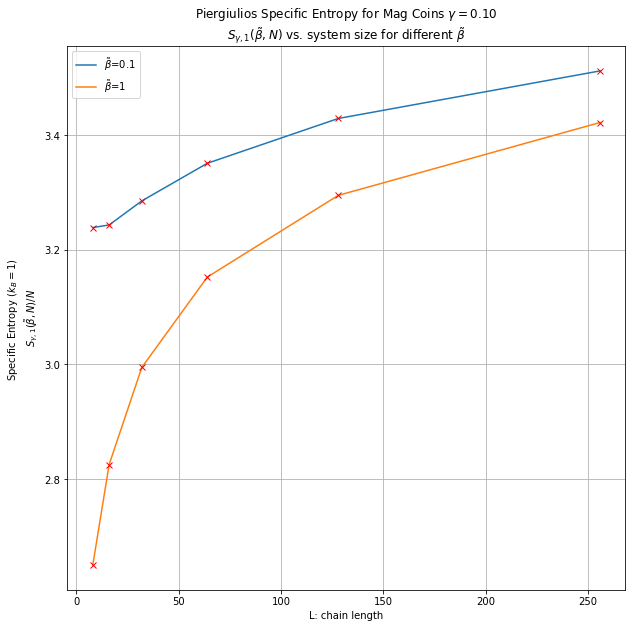

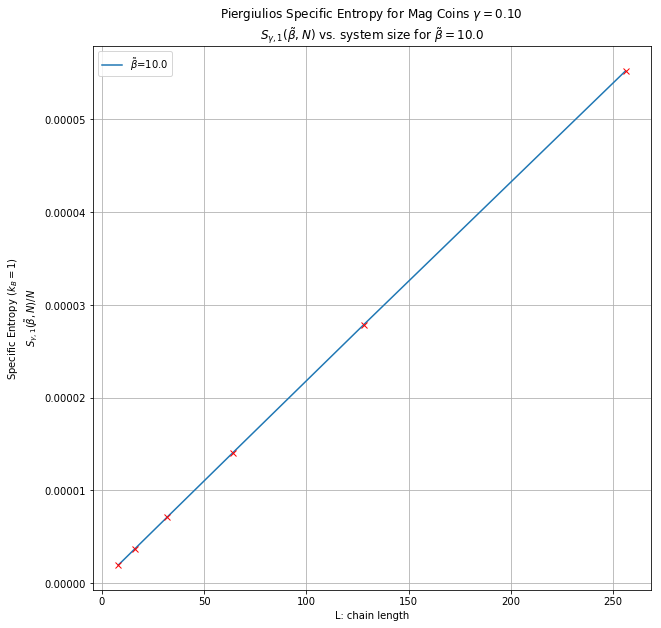

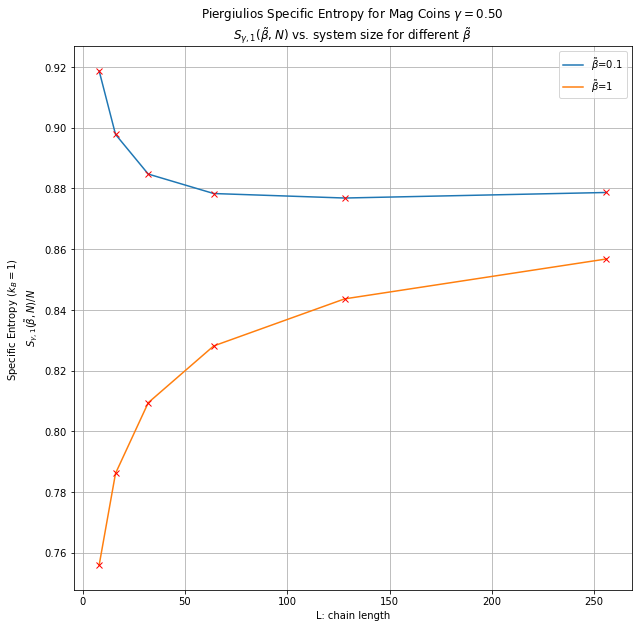

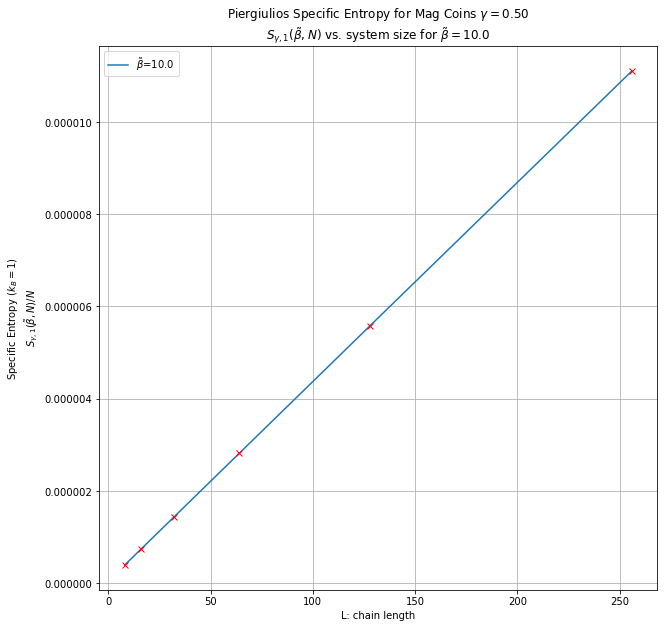

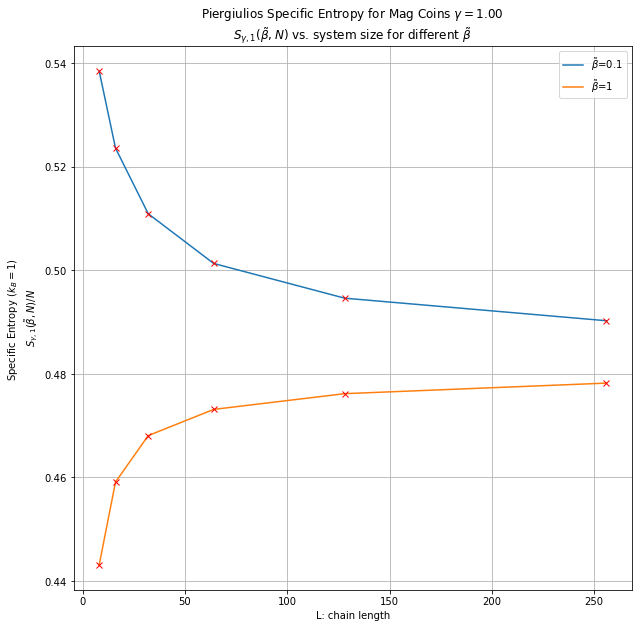

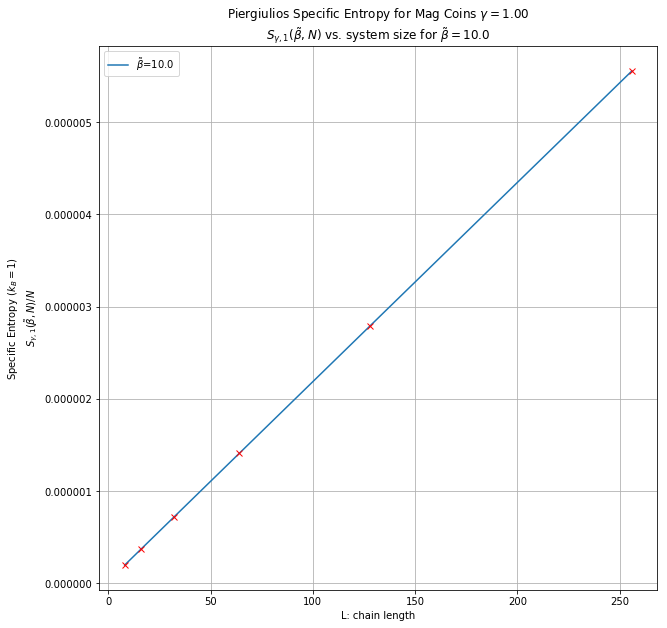

In [142]:
sizes = [8,16,32,64,128,256]
for gamma in [0.1, 0.5, 1.0]:
    T_0_1 = list(map(lambda n: specific_entropy(n,0.1,gamma),sizes))
    T1 = list(map(lambda n: specific_entropy(n,1.0,gamma),sizes))
    T10 = list(map(lambda n: specific_entropy(n,10.0,gamma),sizes))

    plt.plot(sizes,T_0_1,label=r'$\tilde{\beta}$=0.1')
    plt.plot(sizes,T_0_1,'rx')
    plt.plot(sizes,T1,label=r'$\tilde{\beta}$=1')
    plt.plot(sizes,T1,'rx')
    plt.grid()
    plt.legend()
    plt.title('Piergiulios Specific Entropy for Mag Coins $\gamma=$%.2f \n'%gamma + r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for different $\tilde{\beta}$')
    plt.xlabel('L: chain length')
    plt.ylabel('Specific Entropy ($k_B = 1$) \n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
    plt.show()

    plt.plot(sizes,T10,label=r'$\tilde{\beta}$=10.0')
    plt.plot(sizes,T10,'rx')
    plt.grid()
    plt.legend()
    plt.title('Piergiulios Specific Entropy for Mag Coins $\gamma=$%.2f \n'%gamma + r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for $\tilde{\beta}=10.0$')
    plt.xlabel('L: chain length')
    plt.ylabel('Specific Entropy ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
    #plt.yscale('log')
    plt.show()

# ratio

## $\frac{S_{\gamma,1}(\tilde{\beta},N)/N}{S_{\gamma,1}(\tilde{\beta},N=16)/16}$

The following graphs shows the Specific Entropy scaled by the value for $N=16$ for different $\tilde{\beta}$ and $\gamma$. None are constant.

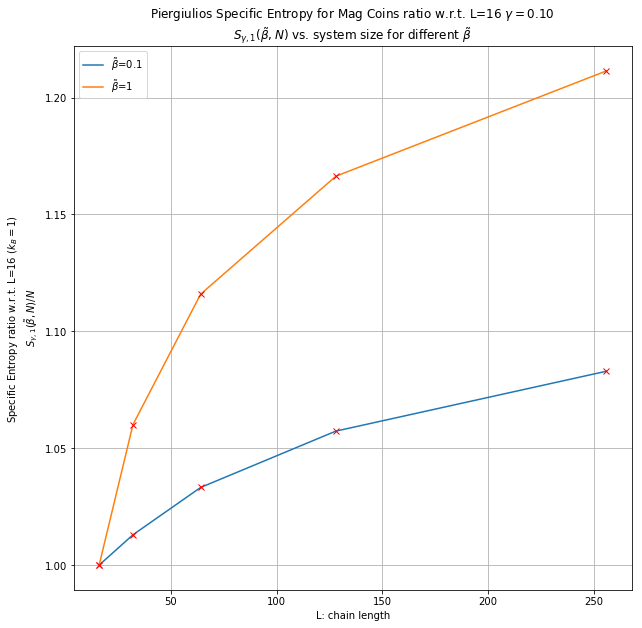

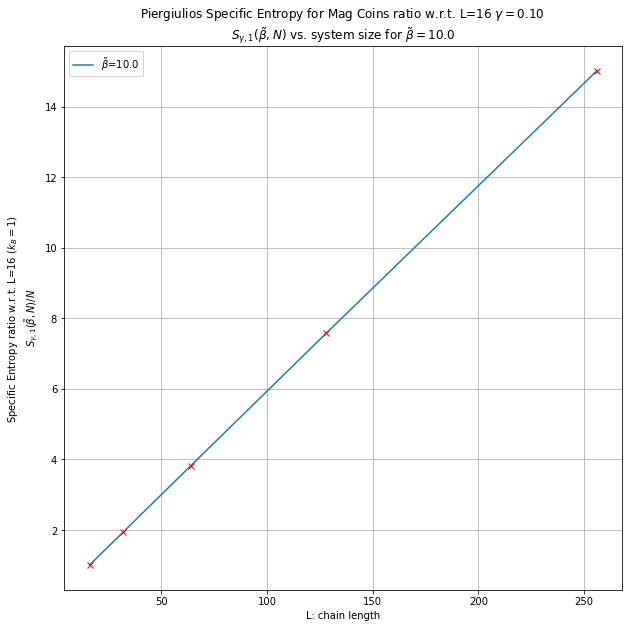

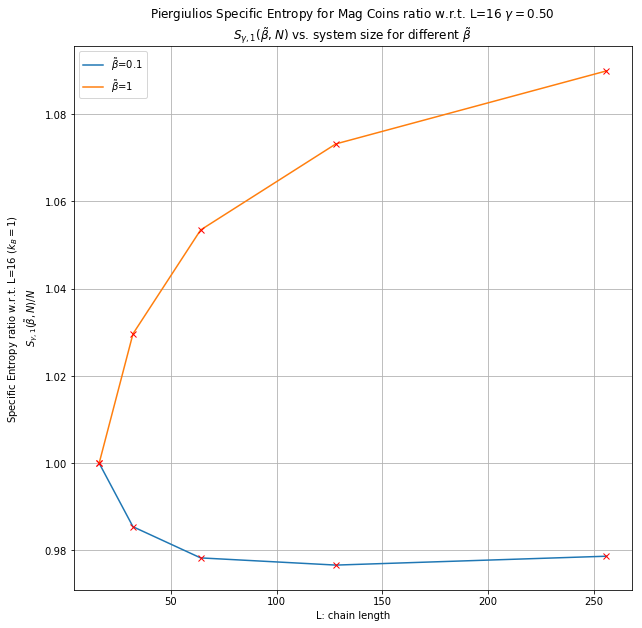

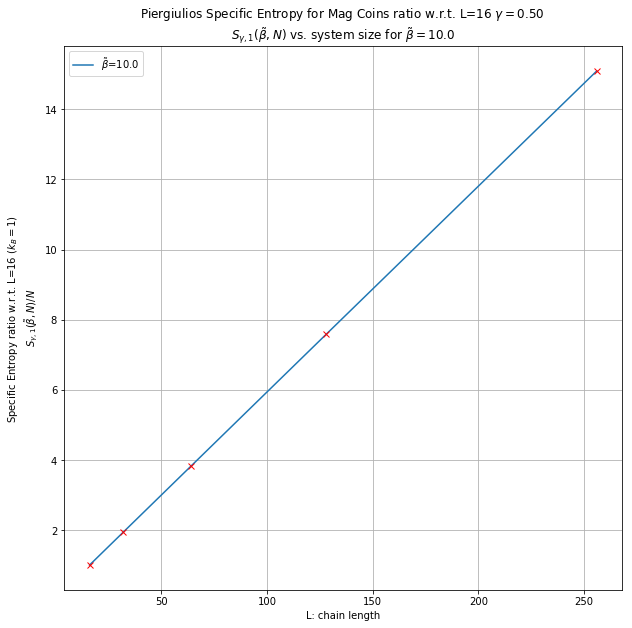

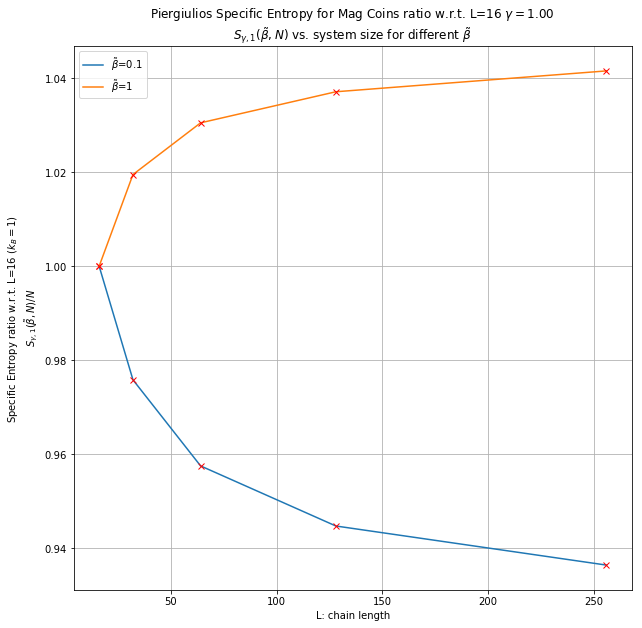

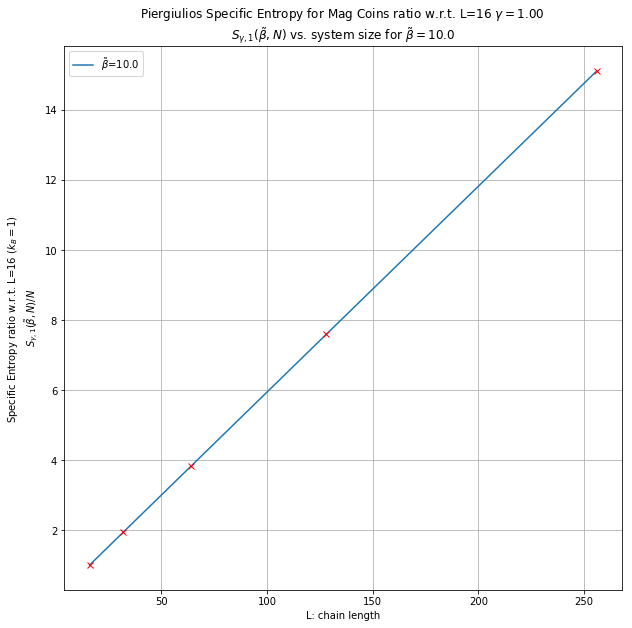

In [143]:
sizes = [16,32,64,128,256]
for gamma in [0.1, 0.5, 1.0]:
    T_0_1 = list(map(lambda n: specific_entropy(n,0.1,gamma)/specific_entropy(16,0.1,gamma),sizes))
    T1 = list(map(lambda n: specific_entropy(n,1.0,gamma)/specific_entropy(16,1.0,gamma),sizes))
    T10 = list(map(lambda n: specific_entropy(n,10.0,gamma)/specific_entropy(16,10.0,gamma),sizes))

    plt.plot(sizes,T_0_1,label=r'$\tilde{\beta}$=0.1')
    plt.plot(sizes,T_0_1,'rx')
    plt.plot(sizes,T1,label=r'$\tilde{\beta}$=1')
    plt.plot(sizes,T1,'rx')
    plt.grid()
    plt.legend()
    plt.title('Piergiulios Specific Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=$%.2f \n'%gamma + r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for different $\tilde{\beta}$')
    plt.xlabel('L: chain length')
    plt.ylabel('Specific Entropy ratio w.r.t. L=16 ($k_B = 1$) \n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
    plt.show()

    plt.plot(sizes,T10,label=r'$\tilde{\beta}$=10.0')
    plt.plot(sizes,T10,'rx')
    plt.grid()
    plt.legend()
    plt.title('Piergiulios Specific Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=$%.2f \n'%gamma+ r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for $\tilde{\beta}=10.0$')
    plt.xlabel('L: chain length')
    plt.ylabel('Specific Entropy ratio w.r.t. L=16 ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
    #plt.yscale('log')
    plt.show()

# Entropy ratio Alone

##  $S_{\gamma,1}(\tilde{\beta},N)$
## $\frac{S_{\gamma,1}(\tilde{\beta},N)}{S_{\gamma,1}(\tilde{\beta},N=16)}$

### Tried the same procedure, for Entropy (Not Specific one). 

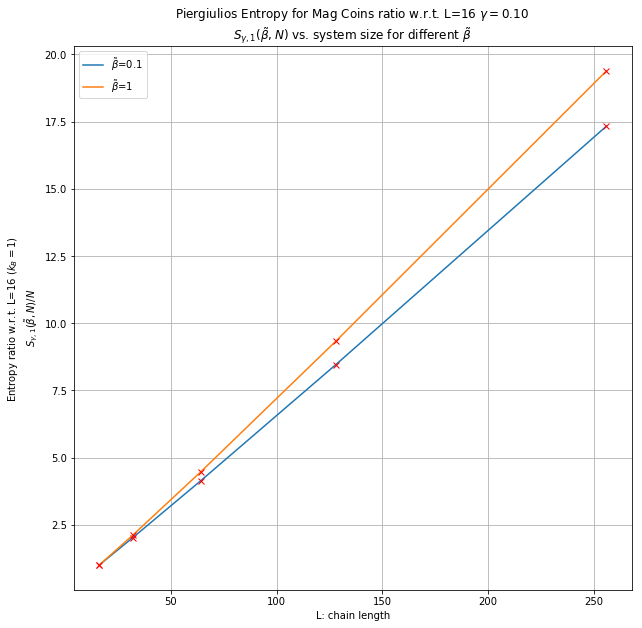

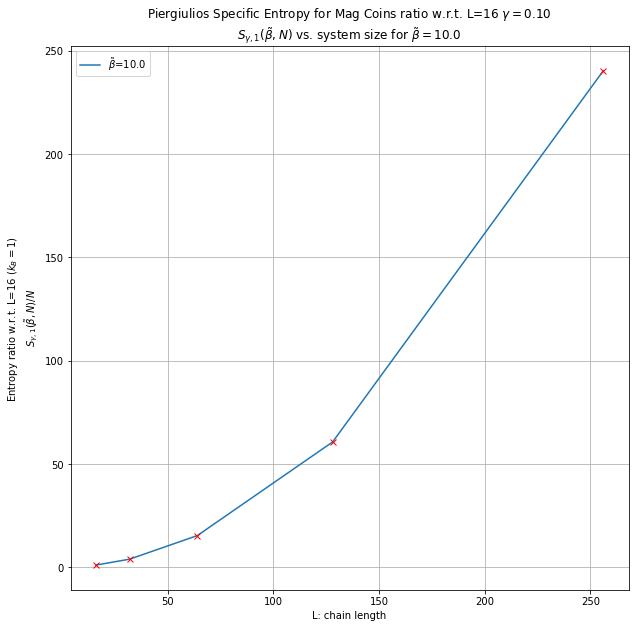

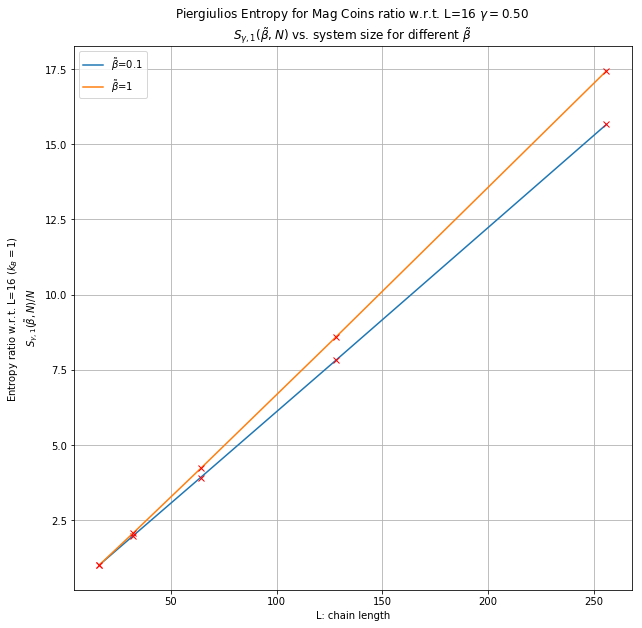

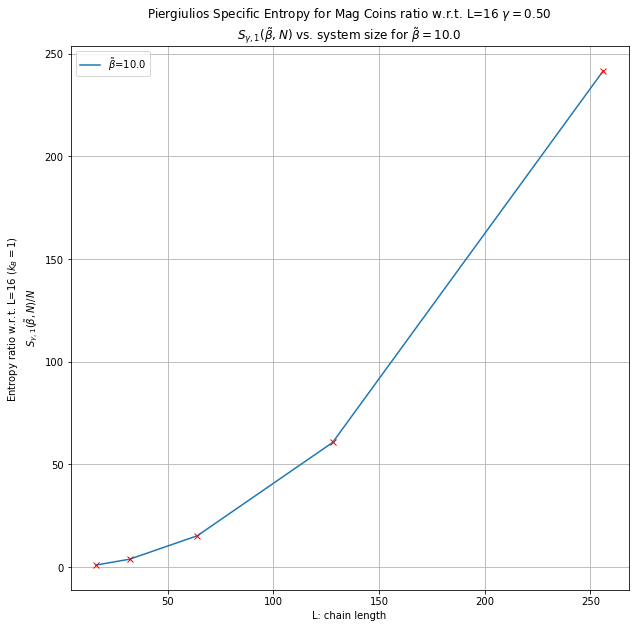

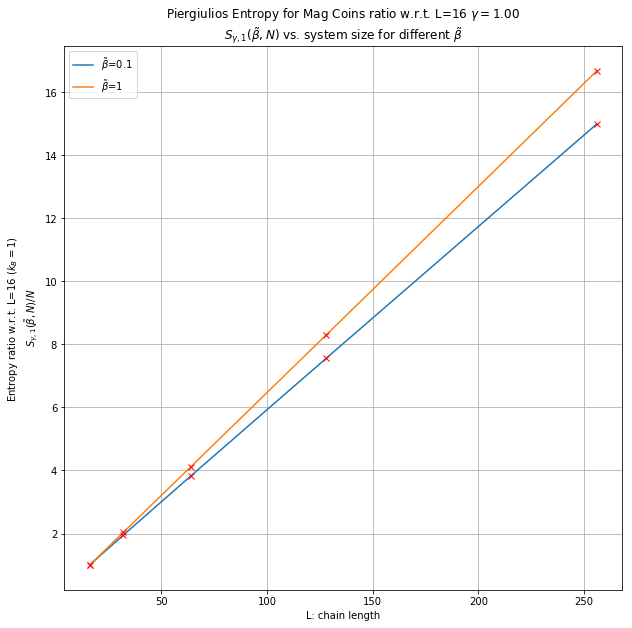

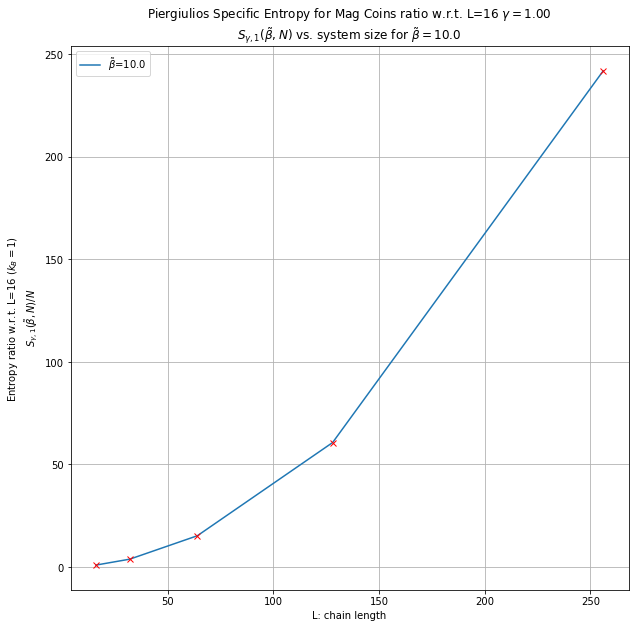

In [144]:
sizes = [16,32,64,128,256]
for gamma in [0.1, 0.5, 1.0]:
    T_0_1 = list(map(lambda n: entropy(n,0.1,gamma)/entropy(16,0.1,gamma),sizes))
    T1 = list(map(lambda n: entropy(n,1.0,gamma)/entropy(16,1.0,gamma),sizes))
    T10 = list(map(lambda n: entropy(n,10.0,gamma)/entropy(16,10.0,gamma),sizes))

    plt.plot(sizes,T_0_1,label=r'$\tilde{\beta}$=0.1')
    plt.plot(sizes,T_0_1,'rx')
    plt.plot(sizes,T1,label=r'$\tilde{\beta}$=1')
    plt.plot(sizes,T1,'rx')
    plt.grid()
    plt.legend()
    plt.title('Piergiulios Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=$%.2f \n'%gamma + r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for different $\tilde{\beta}$')
    plt.xlabel('L: chain length')
    plt.ylabel('Entropy ratio w.r.t. L=16 ($k_B = 1$) \n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
    plt.show()

    plt.plot(sizes,T10,label=r'$\tilde{\beta}$=10.0')
    plt.plot(sizes,T10,'rx')
    plt.grid()
    plt.legend()
    plt.title('Piergiulios Specific Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=$%.2f \n'%gamma+ r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for $\tilde{\beta}=10.0$')
    plt.xlabel('L: chain length')
    plt.ylabel('Entropy ratio w.r.t. L=16 ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
    #plt.yscale('log')
    plt.show()

# Using Correct version of Mag. Coins growth rate

## We know $W(N) \approx  (\kappa N)^{\gamma \kappa N}$ where $\gamma = \frac{e}{2}$ and $\kappa=e^{-1}$.

## Consequently, entropy has the form like 
## $S_{\gamma,\kappa, \alpha}[p] = \kappa^{-1} \{ \exp[L(\frac{\ln(\sum_{i=1}^{W} p_{i}^{\alpha})}{\gamma (1- \alpha)})]-1\}$

## In our case,

## $S_{\frac{e}{2},e^{-1}}[p] = e \times \{ \exp[L(\frac{-2 \sum_{i=1}^{W} p_{i} \ln p_i}{e})]-1\}$

### The details are explained in my report: A Note about the draft of stat_mech_explo_Science_Rep_V4 plus and Idea 21 April 2017. Again, None is constant.

In [145]:

def entropy_L(L,beta_tilde):    
    omega_E = n_E_mag_exact(L)
    Z = partition_F_2(omega_E,beta_tilde)
    e_bar = avg_energy(omega_E,beta_tilde,Z)
    S_B = Decimal(beta_tilde)*e_bar + Z.ln()
    gamma = exp(1.0)/2
    lam = lambertw(float(S_B)/gamma)
    if(lam.imag != 0):
        print('===============================================')
        print('Imaginary part is not zero.')
        print('L:%d, beta_tilde:%.4f gamma:%.4f' % (L,beta_tilde,gamma))
        print('===============================================')

    return exp(1)*exp(lam.real )-1.0

def specific_entropy_L(L,beta_tilde):
    return entropy_L(L,beta_tilde)/L 

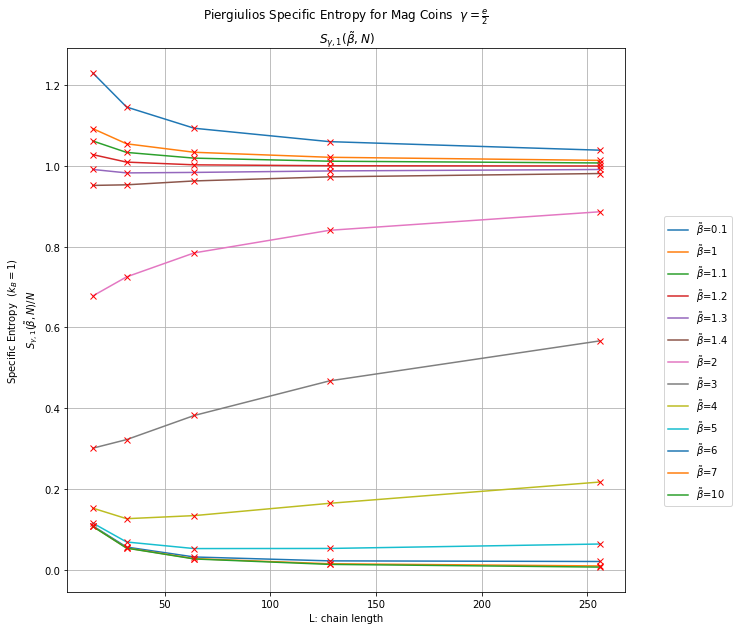

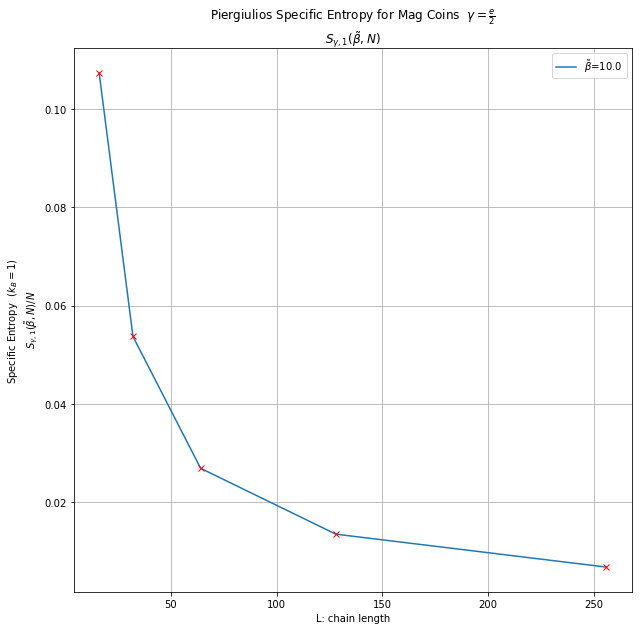

In [171]:
sizes = [16,32,64,128,256]

T_0_1 = list(map(lambda n: specific_entropy_L(n,0.1),sizes))
T1 = list(map(lambda n: specific_entropy_L(n,1.0),sizes))
T1_1 = list(map(lambda n: specific_entropy_L(n,1.1),sizes))
T1_2 = list(map(lambda n: specific_entropy_L(n,1.2),sizes))
T1_3 = list(map(lambda n: specific_entropy_L(n,1.3),sizes))
T1_4 = list(map(lambda n: specific_entropy_L(n,1.4),sizes))
T2 = list(map(lambda n: specific_entropy_L(n,2.0),sizes))
T3 = list(map(lambda n: specific_entropy_L(n,3.0),sizes))
T4 = list(map(lambda n: specific_entropy_L(n,4.0),sizes))
T5 = list(map(lambda n: specific_entropy_L(n,5.0),sizes))
T6 = list(map(lambda n: specific_entropy_L(n,6.0),sizes))
T7 = list(map(lambda n: specific_entropy_L(n,7.0),sizes))
T10 = list(map(lambda n: specific_entropy_L(n,10.0),sizes))

plt.plot(sizes,T_0_1,label=r'$\tilde{\beta}$=0.1')
plt.plot(sizes,T_0_1,'rx')
plt.plot(sizes,T1,label=r'$\tilde{\beta}$=1')
plt.plot(sizes,T1,'rx')
plt.plot(sizes,T1_1,label=r'$\tilde{\beta}$=1.1')
plt.plot(sizes,T1_1,'rx')
plt.plot(sizes,T1_2,label=r'$\tilde{\beta}$=1.2')
plt.plot(sizes,T1_2,'rx')
plt.plot(sizes,T1_3,label=r'$\tilde{\beta}$=1.3')
plt.plot(sizes,T1_3,'rx')
plt.plot(sizes,T1_4,label=r'$\tilde{\beta}$=1.4')
plt.plot(sizes,T1_4,'rx')
plt.plot(sizes,T2,label=r'$\tilde{\beta}$=2')
plt.plot(sizes,T2,'rx')
plt.plot(sizes,T3,label=r'$\tilde{\beta}$=3')
plt.plot(sizes,T3,'rx')
plt.plot(sizes,T4,label=r'$\tilde{\beta}$=4')
plt.plot(sizes,T4,'rx')
plt.plot(sizes,T5,label=r'$\tilde{\beta}$=5')
plt.plot(sizes,T5,'rx')
plt.plot(sizes,T6,label=r'$\tilde{\beta}$=6')
plt.plot(sizes,T6,'rx')
plt.plot(sizes,T7,label=r'$\tilde{\beta}$=7')
plt.plot(sizes,T7,'rx')
plt.plot(sizes,T10,label=r'$\tilde{\beta}$=10')
plt.plot(sizes,T10,'rx')
plt.grid()
plt.legend(bbox_to_anchor=(1.2,0.7))
plt.title(r'Piergiulios Specific Entropy for Mag Coins  $\gamma=\frac{e}{2}$'+ '\n'+ r'$S_{\gamma,1}(\tilde{\beta},N)$'  )
plt.xlabel('L: chain length')
plt.ylabel('Specific Entropy  ($k_B = 1$) \n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
plt.show()

plt.plot(sizes,T10,label=r'$\tilde{\beta}$=10.0')
plt.plot(sizes,T10,'rx')
plt.grid()
plt.legend()
plt.title(r'Piergiulios Specific Entropy for Mag Coins  $\gamma=\frac{e}{2}$'+'\n'+ r'$S_{\gamma,1}(\tilde{\beta},N)$' )
plt.xlabel('L: chain length')
plt.ylabel('Specific Entropy  ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
#plt.yscale('log')
plt.show()

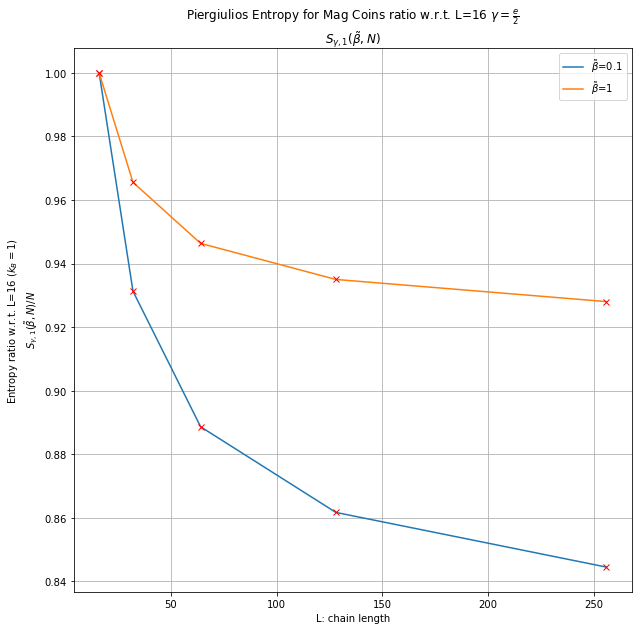

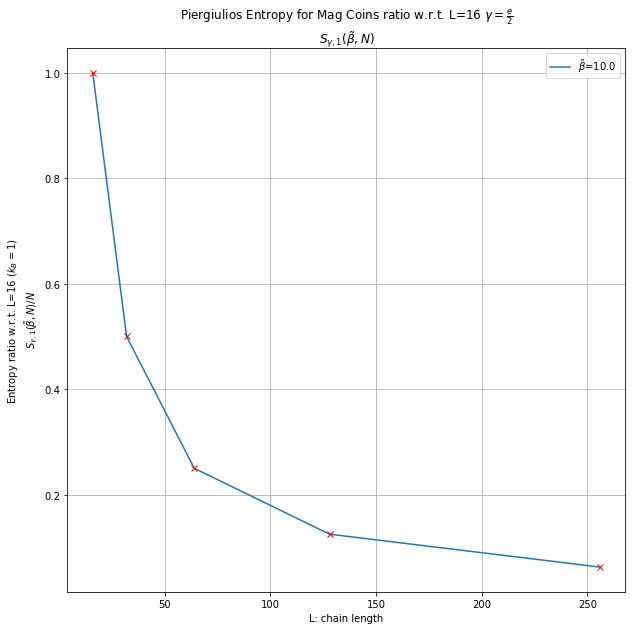

In [173]:
sizes = [16,32,64,128,256]

T_0_1 = list(map(lambda n: specific_entropy_L(n,0.1)/specific_entropy_L(16,0.1),sizes))
T1 = list(map(lambda n: specific_entropy_L(n,1.0)/specific_entropy_L(16,1.0),sizes))
T10 = list(map(lambda n: specific_entropy_L(n,10.0)/specific_entropy_L(16,10.0),sizes))

plt.plot(sizes,T_0_1,label=r'$\tilde{\beta}$=0.1')
plt.plot(sizes,T_0_1,'rx')
plt.plot(sizes,T1,label=r'$\tilde{\beta}$=1')
plt.plot(sizes,T1,'rx')
plt.grid()
plt.legend()
plt.title(r'Piergiulios Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=\frac{e}{2}$'+ '\n'+ r'$S_{\gamma,1}(\tilde{\beta},N)$'  )
plt.xlabel('L: chain length')
plt.ylabel('Entropy ratio w.r.t. L=16 ($k_B = 1$) \n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
plt.show()

plt.plot(sizes,T10,label=r'$\tilde{\beta}$=10.0')
plt.plot(sizes,T10,'rx')
plt.grid()
plt.legend()
plt.title(r'Piergiulios Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=\frac{e}{2}$'+'\n'+ r'$S_{\gamma,1}(\tilde{\beta},N)$' )
plt.xlabel('L: chain length')
plt.ylabel('Entropy ratio w.r.t. L=16 ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
#plt.yscale('log')
plt.show()

# $\tilde{\beta} \rightarrow 0$

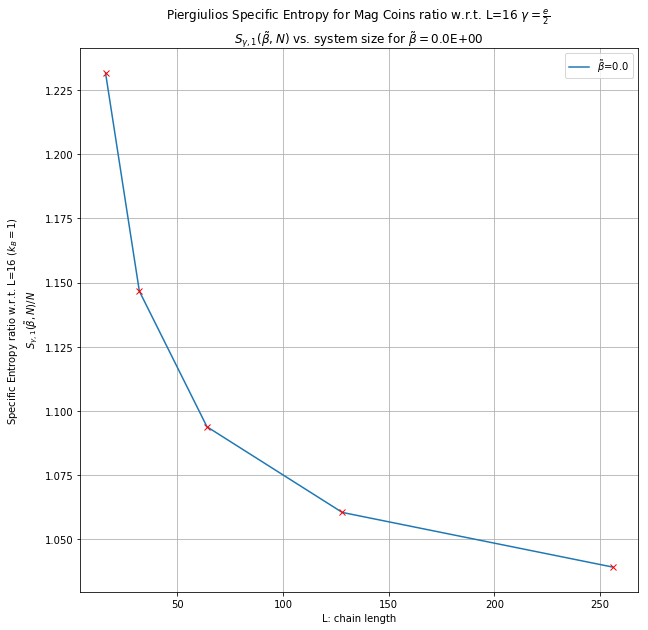

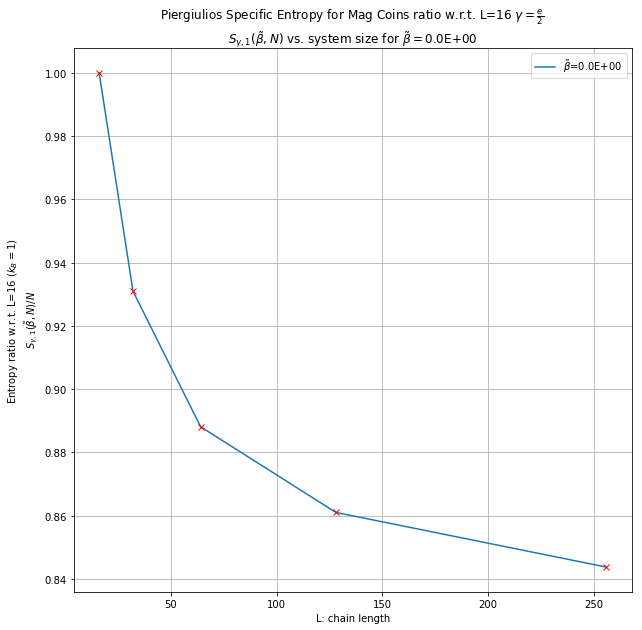

In [178]:
sizes = [16,32,64,128,256]
beta = 0.0#1e-8

T_0_1 = list(map(lambda n: specific_entropy_L(n,beta),sizes))
plt.plot(sizes,T_0_1,label=r'$\tilde{\beta}$=0.0')
plt.plot(sizes,T_0_1,'rx')
plt.grid()
plt.legend()
plt.title(r'Piergiulios Specific Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=\frac{e}{2}$'+' \n'+ r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for $\tilde{\beta}=$' + '%.1E' % beta)
plt.xlabel('L: chain length')
plt.ylabel('Specific Entropy ratio w.r.t. L=16 ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
#plt.yscale('log')
plt.show()
    
T_0_1 = list(map(lambda n: specific_entropy_L(n,beta)/specific_entropy_L(16,beta),sizes))


plt.plot(sizes,T_0_1,label=r'$\tilde{\beta}$=' + '%.1E'%beta)
plt.plot(sizes,T_0_1,'rx')
plt.grid()
plt.legend()
plt.title(r'Piergiulios Specific Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=\frac{e}{2}$'+' \n'+ r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for $\tilde{\beta}=$' + '%.1E' % beta)
plt.xlabel('L: chain length')
plt.ylabel('Entropy ratio w.r.t. L=16 ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
#plt.yscale('log')
plt.show()

L:128, Beta=0.0, gamma:e/2
Z:	2.185682E+116
Inverse Z:	4.57523168760024E-117
	1/W:	4.57523168760021E-117
<E>/N:	8.06E-67
S_B:	267.88
lambert:	(3.91808898297+0j)
Entropy:	135.74 
Specific Entropy:	1.06 


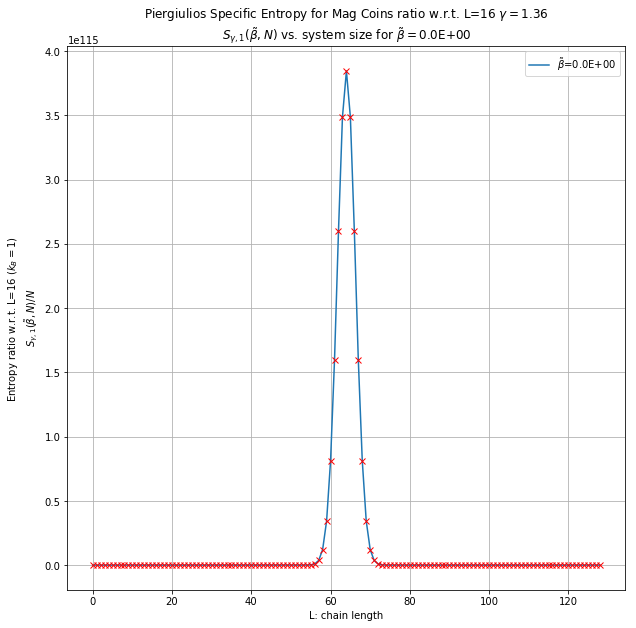

In [175]:
L=128
gamma = exp(1.0)/2.0
beta_tilde = 0.0

omega_E = n_E_mag_exact(L)
Z = partition_F_2(omega_E,beta_tilde)
print('============================================')
print('============================================')
print('============================================')
print('L:%d, Beta=0.0, gamma:e/2' % L)
print('Z:\t%.6E' % (Z,))
print('Inverse Z:\t%.14E' % (Decimal(1.0)/Z,))
print('\t1/W:\t%.14E' % (1.0/sum(omega_E)))
print('============================================')
print('============================================')
print('============================================')
e_bar = avg_energy(omega_E,beta_tilde,Z)
print('<E>/N:\t%.2E' % (e_bar/L))
S_B = Decimal(beta_tilde)*e_bar + Z.ln()
print('S_B:\t%.2f' % S_B)
lam = lambertw(float(S_B)/gamma)
print('lambert:\t' + str(lam))
if(lam.imag != 0):
    print('===============================================')
    print('Imaginary part is not zero.')
    print('L:%d, beta_tilde:%.4f gamma:%.4f' % (L,beta_tilde,gamma))
    print('===============================================')

S_gamma = exp(1)*exp(lam.real)-1.0
print('Entropy:\t%.2f ' % S_gamma)
print('Specific Entropy:\t%.2f ' % (S_gamma/L))

plt.plot(omega_E,label=r'$\tilde{\beta}$=' + '%.1E'%beta)
plt.plot(omega_E,'rx')
plt.grid()
plt.legend()
plt.title('Piergiulios Specific Entropy for Mag Coins ratio w.r.t. L=16 $\gamma=$%.2f \n'%gamma+ r'$S_{\gamma,1}(\tilde{\beta},N)$ vs. system size for $\tilde{\beta}=$' + '%.1E' % beta)
plt.xlabel('L: chain length')
plt.ylabel('Entropy ratio w.r.t. L=16 ($k_B = 1$)\n'+r' $S_{\gamma,1}(\tilde{\beta},N)/N$ ')
#plt.yscale('log')
plt.show()